<a href="https://colab.research.google.com/github/AlirezaFB01/Machine-learning/blob/main/Neural_Networks_Improving_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Setup

In this notebook we are going to work with the `EMNIST` dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader

import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


In [19]:
# @title plotting functions

def plot_results(train_losses, train_accs, test_losses, test_accs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label='Train')
    axes[0].plot(xs, test_losses, label='Test')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label='Train')
    axes[1].plot(xs, test_accs, label='Test')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [20]:
# @title helper functions


def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader, test_loader, device=device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        test_loss, test_acc = test_step(model, criterion, test_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Test Loss = {test_loss:.3f} | Test Acc = {test_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), train_accs.append(train_acc), test_losses.append(test_loss), test_accs.append(test_acc)
    # Plot the results
    plot_results(train_losses, train_accs, test_losses, test_accs)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'test_loss': test_losses, 'test_acc': test_accs}

# Loading the `EMNIST` Data

To work with the data we must first download the dataset using `EMNIST`. We will normalize our data as well to get better results during training.

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

classes = train_dataset.classes
print(f'Classes:\n{classes}')

100%|██████████| 562M/562M [00:18<00:00, 30.1MB/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Train dataset size: 112800
Test dataset size: 18800
Classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


As always, we must next define our dataloaders.

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Iterate over the data
for x, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# First Try: Simple Net

First we start working by a simple neural network.

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

We will use a simple stochastic gradient descent optimizer and train the model.

Train Loss = 1.178 | Train Acc = 66.06% | Test Loss = 1.192 | Test Acc = 65.56% : 100%|██████████| 30/30 [15:30<00:00, 31.03s/it]


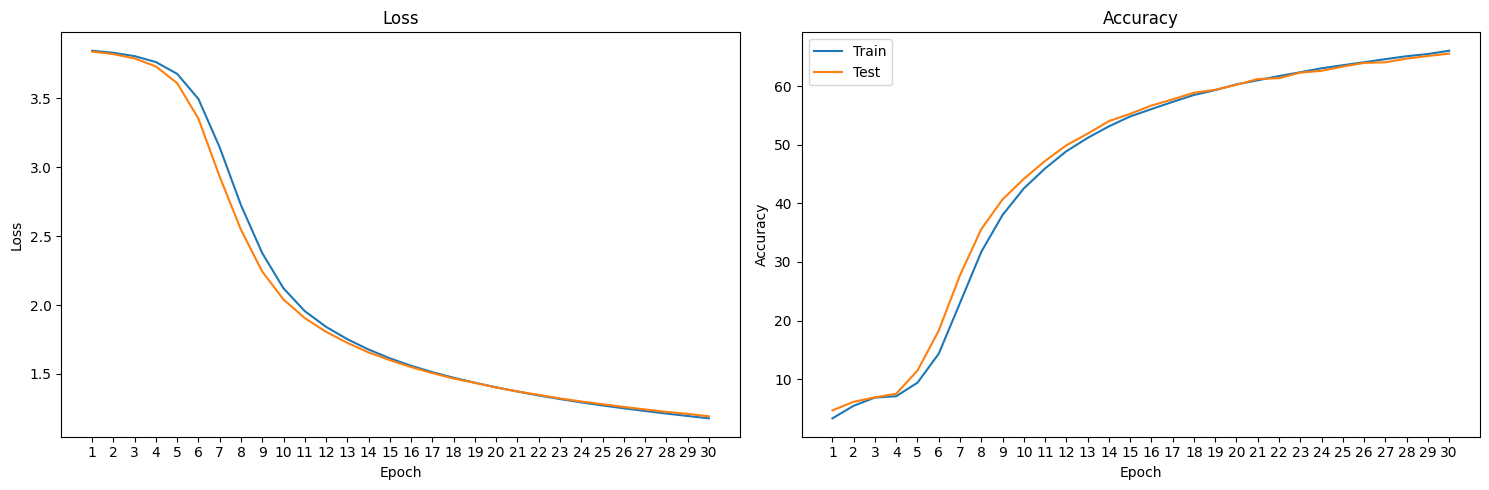

In [7]:
model = SimpleNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)

results = train_model(model, 30, optimizer, train_loader, test_loader)

It appears this dataset is far more challenging than the original `MNIST` digits dataset.


# Second Try: Adam Optimizer

As you recall, we can use better optimizers to speed up convergence.
Usually, the `Adam` optimizer is a good choice.

Train Loss = 0.370 | Train Acc = 86.49% | Test Loss = 0.551 | Test Acc = 82.88% : 100%|██████████| 20/20 [10:28<00:00, 31.42s/it]


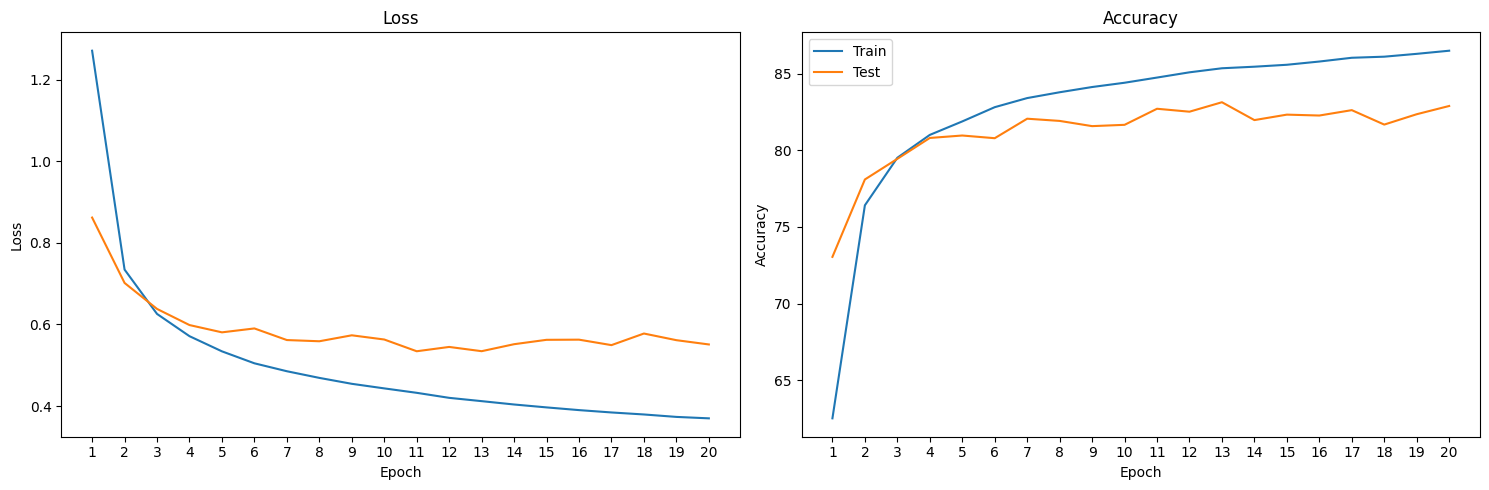

In [8]:
model = SimpleNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

Wow! Evidently replacing `SGD` with `Adam` improved our resutls drastically! 🔥

# Third Try: Deeper Network

Perhaps a bigger network could yield better results.

In [9]:
class BiggerNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 512),
                                     nn.ReLU(), nn.Linear(512, 512),
                                     nn.ReLU(), nn.Linear(512, 512),
                                     nn.ReLU(), nn.Linear(512, 256),
                                     nn.ReLU(), nn.Linear(256, 256),
                                     nn.ReLU(), nn.Linear(256, 256),
                                     nn.ReLU(), nn.Linear(256, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 64),
                                     nn.ReLU(), nn.Linear(64, 64),
                                     nn.ReLU(), nn.Linear(64, 64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.463 | Train Acc = 85.16% | Test Loss = 0.595 | Test Acc = 82.49% : 100%|██████████| 20/20 [11:41<00:00, 35.07s/it]


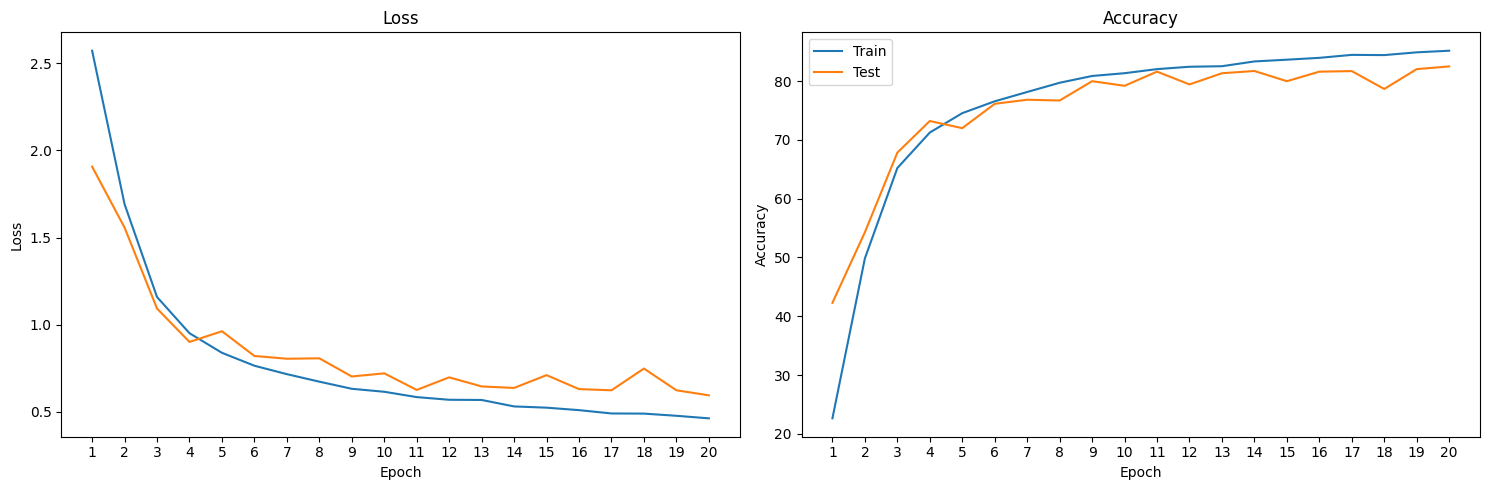

In [10]:
model = BiggerNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

Hmm 🤔 it seems that making the network deeper wasn't that helpful. How can this be?

After all this bigger network has more representative power.
We will try to address this issue next.

# Fourth Try: Batch Normalization

Batch normalization does wonders for better optimization, especially as the networks get deeper!

In [11]:
class BiggerBN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerBN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.272 | Train Acc = 89.80% | Test Loss = 0.439 | Test Acc = 86.15% : 100%|██████████| 20/20 [13:13<00:00, 39.65s/it]


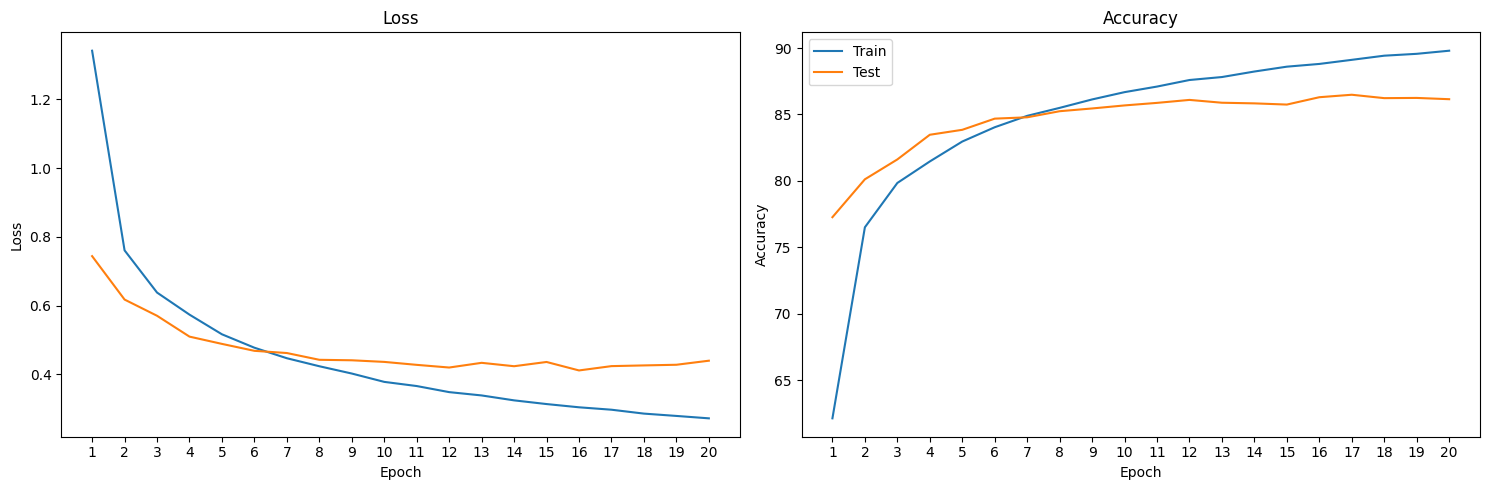

In [12]:
model = BiggerBN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

As you can see this really helped increase the accuracy, however there is something wrong.
Can you spot it?

As you can see there is a gap between our train and test losses and accuracies.
In other words we are observing **overfitting**!
Our next approach will focus on this issue.

# Fifth Try: Dropout

In [17]:
class BiggerDO(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerDO, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.479 | Train Acc = 84.42% | Test Loss = 0.421 | Test Acc = 85.99% : 100%|██████████| 20/20 [13:43<00:00, 41.17s/it]


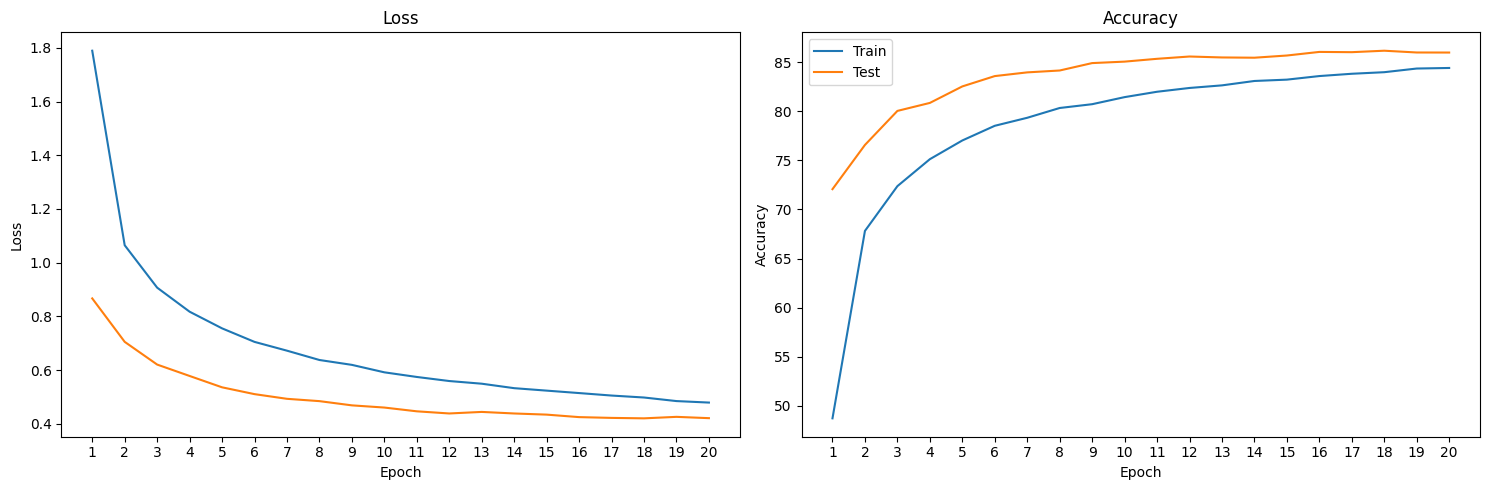

In [16]:
model = BiggerDO(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

This time the generalization gap is not as wide as before.
In fact here we are getting better results on our test set than our training set.
This means we are underfitting (keep in mind `model.eval()` disables the dropout layers and stops updating the batch normalization, however `model.train()` enables them again).

Our next and final approach takes note that the training curve flattens near the end, therefore using smaller learning rates can help with the optimization process.

# Sixth Try: Hyperparameter Tuning

This time we won't initialize a new network, instead we will continue training with a smaller learning rate.

Train Loss = 0.376 | Train Acc = 87.14% | Test Loss = 0.382 | Test Acc = 87.33% : 100%|██████████| 10/10 [06:49<00:00, 40.92s/it]


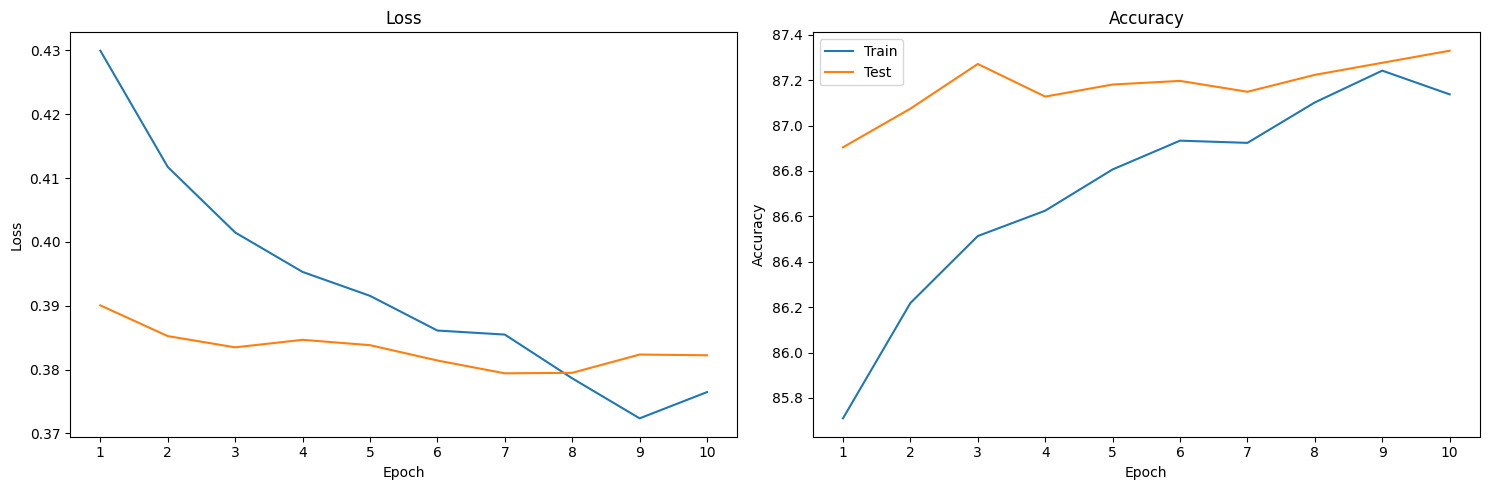

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

results = train_model(model, 10, optimizer, train_loader, test_loader)

# Final Remarks

This notebook is to give you some sense as to how we go about improving neural networks.
The process involves a fair bit of experimentation.
However you should have the following takeaways from this notebook:
*   When in doubt, go with `Adam` as this also allows us to train for epochs or
*   use `Deeper Networks` that will outperform samller networks.
*   `Batch Normalization` does wonders!
*   `Dropout` layers can help with overfitting.
*   `Hyperparameter Tuning` can improve resutls as well.

A number of tips that were not covered in this notebook but you should keep in mind:
*   `Data Augmentation` can really help (don't worry we will learn more about this in the next chapter)
*   Incorporating the `Inductive Bias` allows us to come up with better architectures which in turn will yield much better results more efficiently! (our next two chapters will focus on the concept of different architectures)
*   Sometimes you must tune the hyperparameters to get the results you want.

Keep in mind some of these methods might not work as well as you expect and should always experiment on your own!

As a challenge try and apply the methods covered in this notebook in a different order to see their effects.






